# Give Me Liberty or Give Me… Bankruptcy: Democratic vs. Republican Covid Policies

## Research Question

How did the differing COVID-19 policy prescriptions of California and Florida affect public health and economic conditions in each state respectively? 

From analyzing the difference in health and economic indicators of California and Florida, we would like to generalize the impact of COVID prevention policies similar to California and Florida. We specifically chose California and Florida because of their similar testing rates and because they have radically different COVID prevention policies. Among all the states, California is considered one of the most restrictive, while Florida is considered one of the least.

Specifically, to measure the health impacts of the COVID-19 policies, we will be analyzing tests, positives, and deaths per capita for NY and CA in the month after a policy was enacted. To measure the economic health of the states, we will analyse the unemployment insurance claims in the month after a policy was enacted.

In the future we  plan to conduct t-tests on the difference in means and 2-Sample F Tests to compare the variances of Florida and California over the various categories. We would also like to construct linear regression lines specifically to predict the number of new positive COVID cases based on time after about January of 2021, when both decreased. Once these linear regression lines are constructed, we will like to conduct Linear Regression T Test to determine if the slopes are significantly different.



## Data Collection and Cleaning

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from   sklearn.linear_model import LinearRegression

### Load and Clean Data

In [114]:
## load data
us_covid = pd.read_csv("national-history.csv")
state_covid = pd.read_csv("all-states-history.csv")
state_unemployment = pd.read_csv('unemployment_data.csv')
US_Unemployment = pd.read_csv("US_UnemploymentClaims.csv")
NY_Covid_Policy = pd.read_csv("NY_Covid_Policy.csv")
FL_Covid_Policy = pd.read_csv("FL_Covid_Policy.csv")
state_info = pd.read_csv("state_info.csv")

""""
# To use data hosted on github (to facilitate google colab)
us_covid = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/clean_us_covid.csv?token=AAACQXVVA3UD74247Z5VQ4DAMU5D6")
state_covid = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/all-states-history.csv?token=AAACQXS4PR75L44XM6TPAEDAMU5YI")
NY_Unemployment = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/NY_UnemploymentClaims.csv?token=AAACQXWPNMK2OKGIZ2567LDAMU52M")
FL_Unemployment = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/FL_UnemploymentClaims.csv?token=AAACQXT7H5WUS3EFUR6VQI3AMU54G")
US_Unemployment = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/US_UnemploymentClaims.csv?token=AAACQXS7FBAXWKLL6LQ6SP3AMU554")
NY_Covid_Policy = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/NY_Covid_Policy.csv?token=AAACQXRYMI2FADUAAJ3UJ33AMU6A2")
FL_Covid_Policy = pd.read_csv("https://raw.github.coecis.cornell.edu/erp49/INFO2950/master/FL_Covid_Policy.csv?token=AAACQXW64BGDDXWHMVNWSLLAMU6C6")
"""""
# We may try using this data from the api, but for some reason the graphs aren't working from the api, 
#so right now we're using csvs downloaded from the website

#us_covid = pd.read_csv("https://api.covidtracking.com/v1/us/daily.csv")
#state_covid = pd.read_csv("https://api.covidtracking.com/v1/states/daily.csv")

def cleanUnemployment(df):
    """
    Replaces '' with '_' for column heads and puts them to all lowercase letters. Also convert 'date' column to datetime objects.
    
    Parameter df: data frame to manipulate
    Precondition: df is a pandas dataframe
    """
    new_names = list(df.columns.values)
    new_names = [k.lower() for k in new_names]
    new_names = [k.replace(' ', '_') for k in new_names]
    df.columns = new_names
    df['filed_week_ended']= pd.to_datetime(df['filed_week_ended'])
    df['reflecting_week_ended']= pd.to_datetime(df['reflecting_week_ended'])
    
cleanUnemployment(NY_Unemployment)
cleanUnemployment(FL_Unemployment)

#Change date to datetime object
state_covid['date']= pd.to_datetime(state_covid['date'])
us_covid['date']= pd.to_datetime(us_covid['date'])

US_Unemployment['Date']= pd.to_datetime(US_Unemployment['Date'])
NY_Covid_Policy['Start'] = pd.to_datetime(NY_Covid_Policy['Start'])
FL_Covid_Policy['Start'] = pd.to_datetime(FL_Covid_Policy['Start'])
NY_Covid_Policy['End'] = pd.to_datetime(NY_Covid_Policy['End'])
FL_Covid_Policy['End'] = pd.to_datetime(FL_Covid_Policy['End'])
state_unemployment['Date']= pd.to_datetime(state_unemployment['Date'])


### Add Information and Make Calculations

In [115]:
#Add population, political affiliation, and region information to state_covid dataframe 
state_covid = pd.merge(state_covid, state_info, on='state')

#Calculate % of Tests that are Positive per Increase in Totalt Test Results
state_covid['percentPositiveIncrease'] = state_covid['positiveIncrease'] / state_covid['totalTestResultsIncrease']
us_covid['percentPositiveIncrease'] = us_covid['positiveIncrease'] / us_covid['totalTestResultsIncrease']

#Calculate Increase Rates per 100,0000 for Testing, Positives and Deaths per day
perNum = 100000
US_population = 328.2 * 10**6

us_covid['testingIncreaseRate'] = us_covid["totalTestResultsIncrease"]/US_population * perNum
state_covid['testingIncreaseRate'] = state_covid["totalTestResultsIncrease"]/state_covid["population"] * perNum

us_covid['positiveIncreaseRate'] = us_covid["positiveIncrease"]/US_population * perNum
state_covid['positiveIncreaseRate'] = state_covid["positiveIncrease"]/state_covid["population"] * perNum

us_covid['percent_positiveIncreaseRate'] = us_covid["positiveIncrease"]/us_covid["totalTestResultsIncrease"] * perNum
state_covid['percent_positiveIncreaseRate'] = state_covid["positiveIncrease"]/state_covid["totalTestResultsIncrease"] * perNum

us_covid['deathIncreaseRate'] = us_covid["deathIncrease"]/US_population * perNum
state_covid['deathIncreaseRate'] = state_covid["deathIncrease"]/state_covid["population"]* perNum

#Calculate Total Tests, Positives, and Deaths as a percentage of the population for each day
#(Should only increase, as time increases)
us_covid['testingRate'] = us_covid['totalTestResults']/US_population 
state_covid['testingRate'] = state_covid['totalTestResults']/state_covid["population"]

us_covid['positiveRate'] = us_covid["positive"]/US_population 
state_covid['positiveRate'] = state_covid["positive"]/state_covid["population"] 

us_covid['percent_positiveRate'] = us_covid["positive"]/us_covid['totalTestResults']
state_covid['percent_positiveRate'] = state_covid["positive"]/state_covid['totalTestResults']

us_covid['deathRate'] = us_covid["death"]/US_population
state_covid['deathRate'] = state_covid["death"]/state_covid["population"]

### Subset Data

In [116]:
gstate_covid = state_covid.groupby(by='Political_Affiliation')

#Get totals from most recent date on 3/07/2021
us_totals = us_covid.loc[us_covid['date']==pd.to_datetime('3-07-2021')]
state_totals = state_covid.loc[state_covid['date']==pd.to_datetime('3-07-2021')]

#Isolate columns of interest
us_totals = us_totals[['testingRate', 'positiveRate', 'percent_positiveRate', 'deathRate']]
state_totals = state_totals[['state', 'testingRate', 'positiveRate', 'percent_positiveRate','deathRate', 'Political_Affiliation', 'Region']]

#Group states by political Affiliation
state_politic = state_totals.groupby(by='Political_Affiliation')

Democratic = state_politic.get_group('Democratic')
Republican = state_politic.get_group('Republican')

#Group states by Region
state_region = state_totals.groupby(by='Region')
state_region_politic = state_totals.groupby(['Region', 'Political_Affiliation'])

Midwest = state_region.get_group('Midwest')
Northeast = state_region.get_group('Northeast')
Pacific = state_region.get_group('Pacific')
South = state_region.get_group('South')
West = state_region.get_group('West')

#Make Same Calculations Specific to People in Democratic and Republican States
state_covid_politic = state_covid[['date','deathIncrease','positiveIncrease', 'totalTestResultsIncrease', 'population', 'Political_Affiliation']].groupby(['Political_Affiliation'])

Dem_covid = state_covid_politic.get_group('Democratic')
Dem_covid = Dem_covid.groupby('date').sum()
Rep_covid = state_covid_politic.get_group('Republican')
Rep_covid = Rep_covid.groupby('date').sum()

Dem_covid['testingIncreaseRate'] = Dem_covid["totalTestResultsIncrease"]/Dem_covid['population'] * perNum
Rep_covid['testingIncreaseRate'] = Rep_covid["totalTestResultsIncrease"]/Rep_covid['population'] * perNum

Dem_covid['positiveIncreaseRate'] = Dem_covid["positiveIncrease"]/Dem_covid['population'] * perNum
Rep_covid['positiveIncreaseRate'] = Rep_covid["positiveIncrease"]/Rep_covid['population'] * perNum

"""
Dem_covid['percent_positiveIncreaseRate'] = Dem_covid["positiveIncrease"]/Dem_covid['totalTestResultsIncrease'] 
Rep_covid['percent_positiveIncreaseRate'] = Rep_covid["positiveIncrease"]/Rep_covid['totalTestResultsIncrease'] 
Dem_covid['percent_positiveIncreaseRate'] = Dem_covid['percent_positiveIncreaseRate'].replace(np.inf, np.nan, inplace=True)
Rep_covid['percent_positiveIncreaseRate'] = Rep_covid['percent_positiveIncreaseRate']. replace(np.inf, np.nan, inplace=True)                                                                                                
Dem_covid['percent_positiveIncreaseRate'] = Dem_covid['percent_positiveIncreaseRate'].fillna(0)
Rep_covid['percent_positiveIncreaseRate'] = Rep_covid['percent_positiveIncreaseRate'].fillna(0)
"""
Dem_covid['deathIncreaseRate'] = Dem_covid["deathIncrease"]/Dem_covid['population'] * perNum
Rep_covid['deathIncreaseRate'] = Rep_covid["deathIncrease"]/Rep_covid['population'] * perNum

Dem_covid.head()
#Isolate CA and FL from state_covid
CA_covid = state_covid.loc[state_covid['state']=='CA']
FL_covid = state_covid.loc[state_covid['state']=='FL']

#Downolad CSVs of cleaned data to local drive
#us_covid.to_csv (r'C:\Users\kathe\OneDrive\Documents\S2-DESKTOP-S9R0JMM\INFO_2950\Final Project\clean_us_covid.csv', index = False, header=True)
#NY_covid.to_csv (r'C:\Users\kathe\OneDrive\Documents\S2-DESKTOP-S9R0JMM\INFO_2950\Final Project\clean_NY_covid.csv', index = False, header=True)
#FL_covid.to_csv (r'C:\Users\kathe\OneDrive\Documents\S2-DESKTOP-S9R0JMM\INFO_2950\Final Project\clean_FL_covid.csv', index = False, header=True)
#state_totals.to_csv (r'C:\Users\kathe\OneDrive\Documents\S2-DESKTOP-S9R0JMM\INFO_2950\Final Project\clean_state_totals.csv', index = False, header=True)

In [61]:
Dem_covid.to_csv(r'C:\Users\kathe\OneDrive\Documents\S2-DESKTOP-S9R0JMM\INFO_2950\Final Project\Dem_covid.csv', index = False, header=True)

## Data Description

### Source (National and state data): https://covidtracking.com/data/download
This large file contains day-by-day covid-19 data for all 50 United States, with rows representing each day for each state (i.e. one entry per state, per day, from 03/07/2020 to 03/07/2021.
Columns attributes include both positive and negative test results, the amount of tests administered, hospitalizations, ventilator use, icu capacity, and daily changes each metric therein.
 This dataset was a volunteer effort published by the Atlantic with funding from The Rockefeller Foundation, among other large institutes, and is largely regarded as the largest conglomeration of such data. It is unlikely that these publishers had control of what data was observed, but they did rely on the data reported by the states themselves - which has faced allegations of manipulation by the states (the governors of both NY and FL have been accused of falsifying reports in the national media).
The underlying data, as reported by the states

### Source (Unemployment claims): https://oui.doleta.gov/unemploy/claims.asp
The columns represent the state (New York or Florida), the week filed for unemployment, how many initial claims there were, reflecting week end, the amount of continued claims, those covered under unemployment, and the insured unemployment rate
This dataset was created to provide information about weekly unemployment claims in New York State.
This report was funded by the United States Department of Labor
The data that was recorded was influenced completely by individuals who filed for unemployment. There may be Individuals that are undocumented citizens, among others, who lost their jobs but did not report it.
The data was processed by …..
The people involved in this data collection are the individuals that are filing for unemployment. Since unemployment is filed with the state, this information has been desensitized by removing personal information. It is not likely that individuals are explicitly told when filing for unemployment that their information will be part of a larger dataset.

### Source (New York state timeline of COVID policy): https://www.investopedia.com/historical-timeline-of-covid-19-in-new-york-city-5071986 
The columns represent the date of the policy enactment and description of the policy itself.
This dataset was created to provide a timeline of the US policies regarding COVID and restrictions/guidelines that were specific to New York.
This dataset was compiled through the work of journalists’ reporting on state and federal government policies.
This sample of data does not appear to be biased because it is not skewed either in favor or against the policies enacted. 

### Source (Florida Timeline of Covid Policy): https://ballotpedia.org/Documenting_Florida%27s_path_to_recovery_from_the_coronavirus_(COVID-19)_pandemic,_2020-2021
The columns represent the date of the policy enactment and description of the policy itself.
This dataset was created to provide a timeline of the US policies regarding COVID and restrictions/guidelines that were specific to Florida.
This dataset was compiled through the work of journalists’ reporting on state and federal government policies.
This sample of data does not appear to be biased because it is not skewed either in favor or against the policies enacted. 


## Data Limitations
We are foremostly limited by the data sets that were available to us. There were many other factors that we considered taking into consideration but there is not publicly available data for.
Some datasets are not updated to recent dates so we must either extrapolate based on ast trends or stop our analyses at the dates that the datasets end at.
It will be difficult to control for all lifestyle differences between FL and NY which could otherwise affect the spread of COVID-19 (i.e. feasibility of being outdoors where spread is less likely, access to private transportation, etc.)
We cannot account for individuals that travelled from New York to Florida, or vice versa. This is particularly notable given the number of ‘snowbirds’ who occupy NY in the summer and FL in the winter - as those migration patterns may spread COVID-19 between the two states and represent an infection in one state that was actually caused by the other states’ actions.

## Exporatory Data Analysis

First, we looked at some basic summary statistics. We calculated the total deathRate, positiveRate, and testingRate for CA, FL, the US and for all Democratic and Republican states. Each rate was calculated by taking the total number of deaths, positives, and tests as of 3/07/2021 and divided that by the respective total populations. For example, if the US has a death rate of 0.00157 it means that about 0.157% of the population has died from COVID. If it has a positive rate of 0.087618, the 8.76% of the population has tested positive for COVID. If it has a testing rate of 1.108546, then there have been about 1.1 tests for every 1 American as 3/07/2021.

In [117]:
s1 = state_totals.loc[(state_totals['state'] == 'CA')] 
s2 = state_totals.loc[(state_totals['state'] == 'FL')]    
states_of_interest = pd.concat([s1,s2]).groupby(by='state')

print(us_totals, '\n')
#We don't actually need the means of CA and FL becuase they each only have one row. I did this for formatting.
print(states_of_interest.mean(), '\n')
print(state_politic.mean())

   testingRate  positiveRate  percent_positiveRate  deathRate
0     1.108546      0.087618              0.079039    0.00157 

       testingRate  positiveRate  percent_positiveRate  deathRate
state                                                            
CA        1.256472      0.088615              0.070527   0.001370
FL        1.040109      0.088892              0.085465   0.001502 

                       testingRate  positiveRate  percent_positiveRate  \
Political_Affiliation                                                    
Democratic                1.327622      0.076266              0.063344   
Republican                0.960772      0.097995              0.123030   

                       deathRate  
Political_Affiliation             
Democratic              0.001442  
Republican              0.001502  


Based on the above information, it seems that California and Florida have simmilar Positve rates and death rates, which are both close to the national average. It appears that California had more testing per capita than Florida. 

The testing and positive rates seemed different for Democratic and Republican states. The death rates looked simmiliar. I wanted to determine if the difference in rates were significant for Democratic and Republican states, so I conducted 3 t-tests. I was also curious about the distribution of rates among Democratic and Republican states, so I drew boxplots.

['testingRate', 'positiveRate', 'percent_positiveRate', 'deathRate']


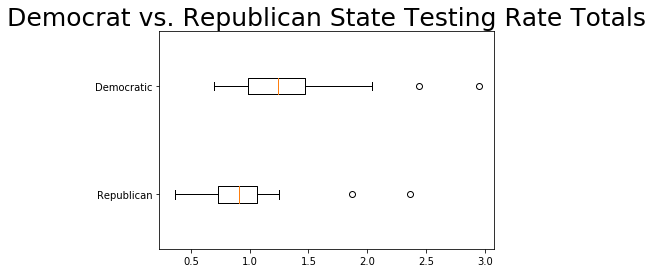

Testing Rate Totals: Ttest_indResult(statistic=-2.647825761328732, pvalue=0.010867406400506143)
SIGNIFICANT 



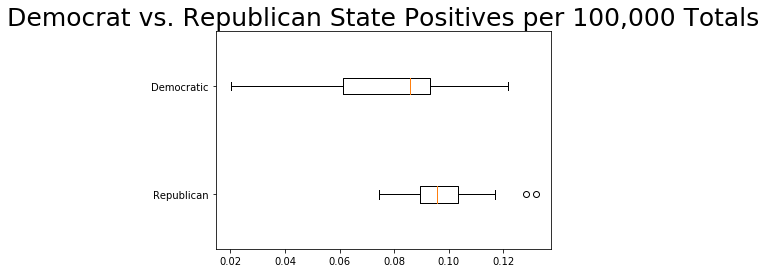

Positives per 100,000 Totals: Ttest_indResult(statistic=3.5463011201158436, pvalue=0.0008712856003042171)
SIGNIFICANT 



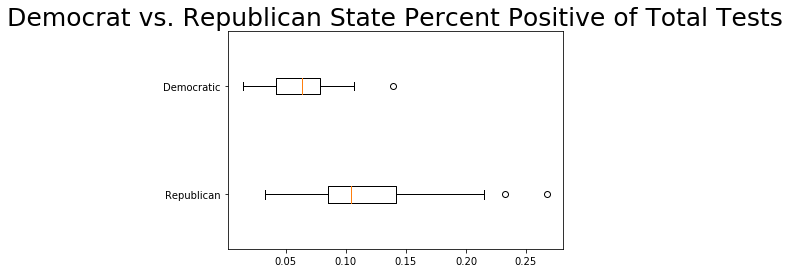

Percent Positive of Total Tests: Ttest_indResult(statistic=4.691813695053396, pvalue=2.2063470586887677e-05)
SIGNIFICANT 



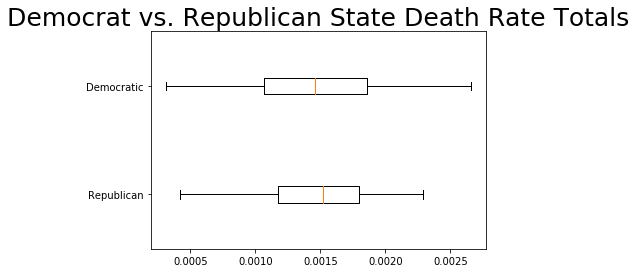

Death Rate Totals: Ttest_indResult(statistic=0.37568848816285105, pvalue=0.7087700622759829)
NOT SIGNIFICANT 



In [118]:
cols_of_interest = list(Democratic.columns.values)[1:-2]
titles = ['Testing Rate Totals', 'Positives per 100,000 Totals', 'Percent Positive of Total Tests','Death Rate Totals']
print(cols_of_interest)
for i in range(len(titles)):
    col = cols_of_interest[i]
    title = 'Democrat vs. Republican State ' + titles[i]
    plt.boxplot([Republican[col], Democratic[col]], labels=['Republican', 'Democratic'], vert=False)
    plt.title(title, fontsize=25)
    plt.show()
    ttest = stats.ttest_ind(Republican[col], Democratic[col])
    is_significant = 'SIGNIFICANT' if ttest.pvalue < 0.05 else 'NOT SIGNIFICANT'
    print(titles[i] + ":", ttest)
    print(is_significant, '\n')
    

Democratic states have significantly more testing that Republican states. Republicans had significantly more positives per 100,000 people than Democratic states, despite conducting less covid tests. However, the difference in death rates was not significant. 

It is important to understand that all of the states were represented equally regardless of population becuase the purpose of the model was to compare testing policy and outcomes of the Democratic and Republican states, not necessarilly the actual populations of the people within Democratic or Republican states. We will test this later. So for example, if Texas had unordinairly low testing rates but also had one of the highest populations, we would not want Texas's testing rates to have too much influence on our understanding of the testing rate policies for all Republican states. 

We also wanted compare the difference in testing rates, positive rates, and death rates for regions in the country. Since there are five regions in the United States, we used ANOVA tests to determine if any one average of a region was statistically significant from the others. If it was, we conducted Tukeys test to determine which regions' average rates were different from the other. 

I was also interested in comparing the rates of different political affiliations within regions. Based on my own background information, I thought there might be differences in policy by region of the country. Political Affiliation may not even be the best representation of the populations' actual political opinions or willingness to adhere to covid guidelines. There's a saying that "a northeastern republican state is more liberal than a southern democratic one. However, when I checked the counts of Democratic and Republican states within the regions, I found that the Northeastern region has only one Republican state. I figured these counts were too small to do more ANOVA and Tukey Tests.

In [114]:
state_region_politic.count()

state  testingRate  positiveRate  deathRate
Region    Political_Affiliation                                             
Midwest   Democratic                 4            4             4          4
          Republican                 8            8             8          8
Northeast Democratic                 8            8             8          8
          Republican                 1            1             1          1
Pacific   Republican                 1            1             1          1
South     Democratic                 8            8             8          8
          Republican                 9            9             9          9
West      Democratic                 7            7             7          7
          Republican                 5            5             5          5

['testingRate', 'positiveRate', 'percent_positiveRate', 'deathRate']


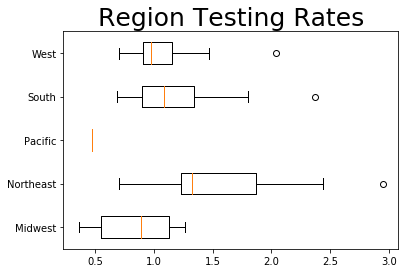

Testing Rates: F_onewayResult(statistic=3.848238911756548, pvalue=0.00885286721700472)
SIGNIFICANT 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2  meandiff p-adj   lower  upper  reject
---------------------------------------------------------
  Midwest Northeast   0.7471 0.0068  0.1565 1.3376   True
  Midwest   Pacific  -0.3825    0.9 -1.7764 1.0114  False
  Midwest     South   0.3504 0.2966 -0.1545 0.8554  False
  Midwest      West   0.2442 0.6883 -0.3026 0.7909  False
Northeast   Pacific  -1.1295 0.1729 -2.5412 0.2821  False
Northeast     South  -0.3967 0.2639 -0.9487 0.1554  False
Northeast      West  -0.5029 0.1286 -1.0934 0.0876  False
  Pacific     South   0.7329 0.5542 -0.6452 2.1109  False
  Pacific      West   0.6266 0.6837 -0.7673 2.0205  False
    South      West  -0.1062    0.9 -0.6112 0.3987  False
---------------------------------------------------------


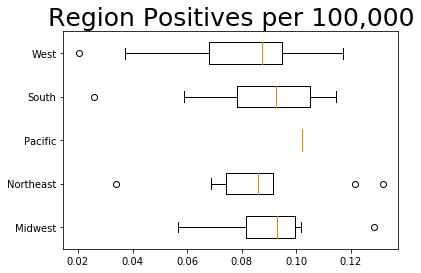

Positives per 100,000: F_onewayResult(statistic=0.4837312727482869, pvalue=0.7475364028985121)
NOT SIGNIFICANT 



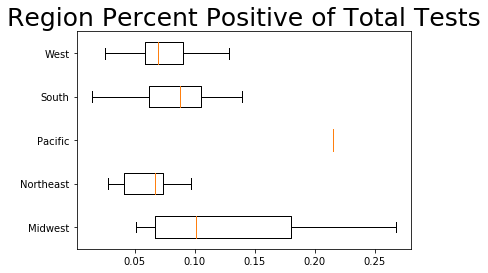

Percent Positive of Total Tests: F_onewayResult(statistic=5.426362039204363, pvalue=0.0011534355579594453)
SIGNIFICANT 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0702 0.0107 -0.1284 -0.0121   True
  Midwest   Pacific   0.0843 0.4198 -0.0529  0.2215  False
  Midwest     South  -0.0458 0.0843 -0.0955  0.0039  False
  Midwest      West  -0.0568  0.034 -0.1106  -0.003   True
Northeast   Pacific   0.1545 0.0225  0.0156  0.2935   True
Northeast     South   0.0245 0.6831 -0.0299  0.0788  False
Northeast      West   0.0135    0.9 -0.0447  0.0716  False
  Pacific     South  -0.1301  0.066 -0.2657  0.0056  False
  Pacific      West  -0.1411 0.0412 -0.2783 -0.0038   True
    South      West   -0.011    0.9 -0.0607  0.0387  False
----------------------------------------------------------


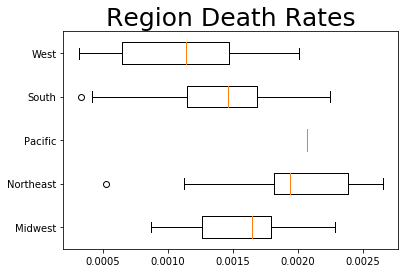

Death Rates: F_onewayResult(statistic=3.114610964203327, pvalue=0.023818727344397238)
SIGNIFICANT 

   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0003 0.6732 -0.0004   0.001  False
  Midwest   Pacific   0.0005 0.8939 -0.0011   0.002  False
  Midwest     South  -0.0002 0.8217 -0.0008  0.0004  False
  Midwest      West  -0.0004 0.2683  -0.001  0.0002  False
Northeast   Pacific   0.0002    0.9 -0.0014  0.0018  False
Northeast     South  -0.0005 0.1555 -0.0011  0.0001  False
Northeast      West  -0.0007 0.0214 -0.0014 -0.0001   True
  Pacific     South  -0.0007 0.6794 -0.0022  0.0008  False
  Pacific      West  -0.0009 0.4494 -0.0025  0.0006  False
    South      West  -0.0002 0.7423 -0.0008  0.0003  False
----------------------------------------------------------


In [119]:
print(cols_of_interest)
titles = ['Testing Rates', 'Positives per 100,000', 'Percent Positive of Total Tests', 'Death Rates']

for i in range(len(titles)):
    col = cols_of_interest[i]
    title = 'Region ' + titles[i]
    data = [ Midwest[col], Northeast[col], Pacific[col], South[col], West[col] ]
    regions = ['Midwest', 'Northeast','Pacific', 'South', 'West']
    plt.boxplot(data, labels=regions, vert=False)
    plt.title(title, fontsize=25)
    plt.show()
    anova = stats.f_oneway(Midwest[col], Northeast[col], Pacific[col], South[col], West[col])
    is_significant = 'SIGNIFICANT' if anova.pvalue < 0.05 else 'NOT SIGNIFICANT'
    print(titles[i] + ":", anova)
    print(is_significant, '\n')
    if is_significant == 'SIGNIFICANT':
        tukey = pairwise_tukeyhsd(endog=state_totals[col], groups=state_totals['Region'], alpha=0.05)
        print(tukey)

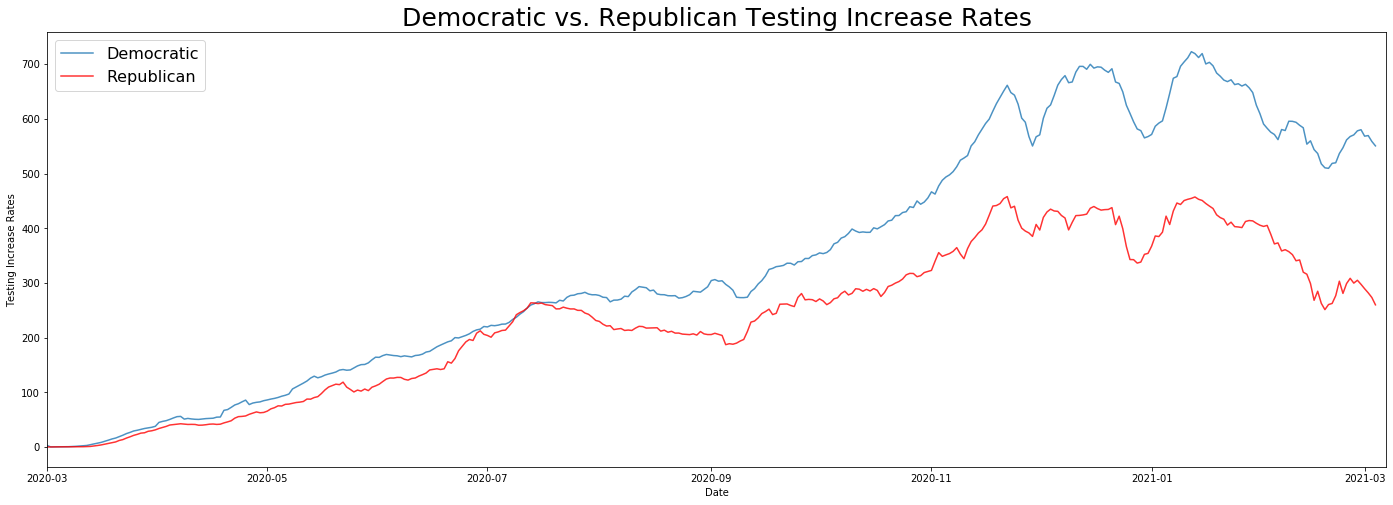

Democratic Average of Testing Increase Rates: 303.6026000566923
Republican Average of Testing Increase Rates: 216.70698215825058
Ttest_indResult(statistic=6.2262532601951275, pvalue=7.612785511483494e-10)


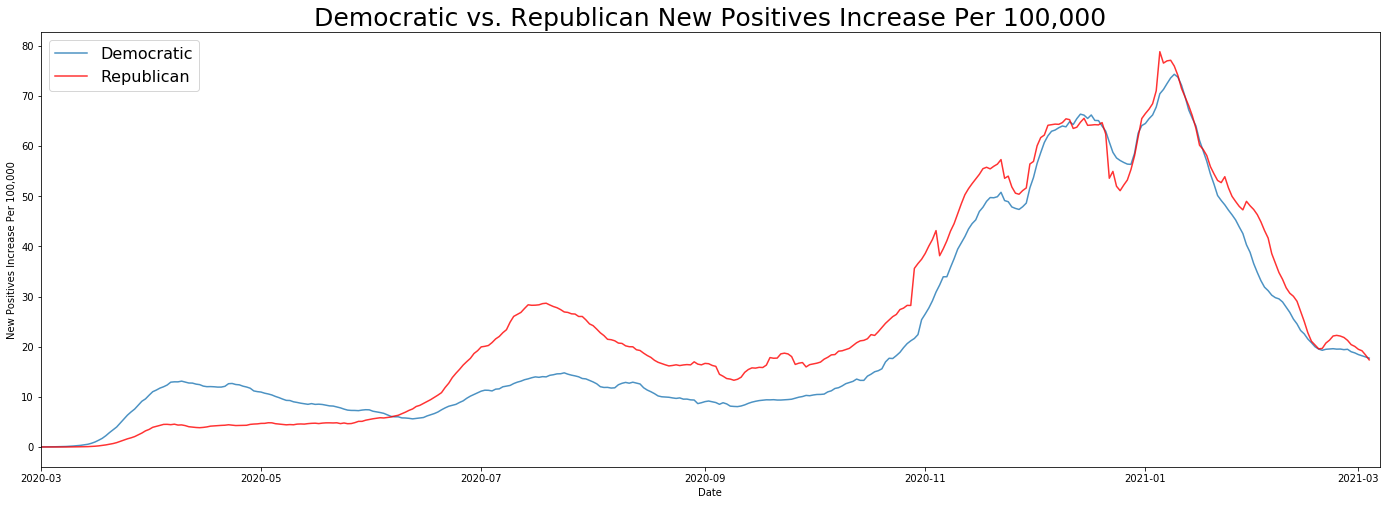

Democratic Average of New Positives Increase Per 100,000: 19.6353677792971
Republican Average of New Positives Increase Per 100,000: 23.23090079258996
Ttest_indResult(statistic=-2.4228218786244744, pvalue=0.015615598133711831)


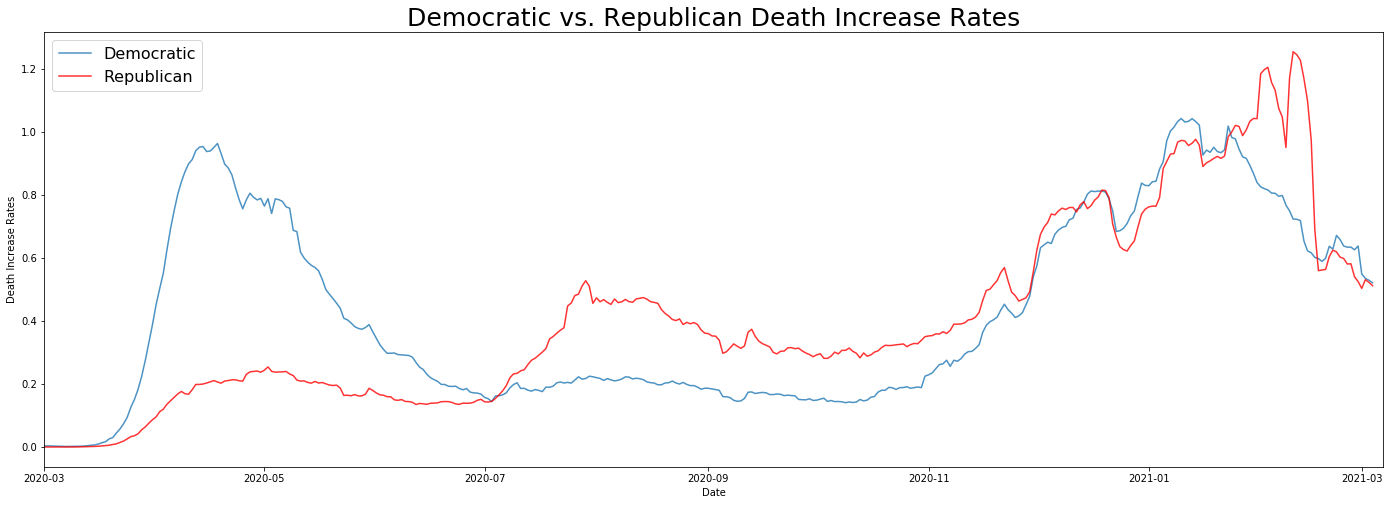

Democratic Average of Death Increase Rates: 0.37894826192270986
Republican Average of Death Increase Rates: 0.3770474425602762
Ttest_indResult(statistic=0.07734031594345926, pvalue=0.9383716402875895)


In [120]:
cols_of_interest = ['testingIncreaseRate', 'positiveIncreaseRate', 'deathIncreaseRate']
titles = ['Testing Increase Rates','New Positives Increase Per 100,000','Death Increase Rates']

for i in range(len(cols_of_interest)):
    plt.figure(figsize=(24,8))
    c = cols_of_interest[i]
    title = titles[i]
    plt.plot( Dem_covid[c].rolling(7, center=True).mean(), alpha=0.8, label='Democratic')
    plt.plot(Rep_covid[c].rolling(7, center=True).mean(), color='red', alpha=0.8, label='Republican')

    plt.xlim(pd.to_datetime('2020-03-1'),pd.to_datetime('2021-03-07'))

    plt.xlabel('Date')
    plt.ylabel(title)
    plt.title('Democratic vs. Republican {}'.format(title), fontsize=25)
    plt.legend(loc=2, fontsize=16)
    plt.show()

    print('Democratic Average of {}: {}'.format(title, Dem_covid[c].mean()))
    print('Republican Average of {}: {}'.format(title, Rep_covid[c].mean()))
    print(stats.ttest_ind(Dem_covid[c], Rep_covid[c]))

Democratic Estimate: y = 0.0007570574533882543x + 0.1491036506817379
Republican Estimate: y = 0.0017374746060789788x + 0.0005245641003060464


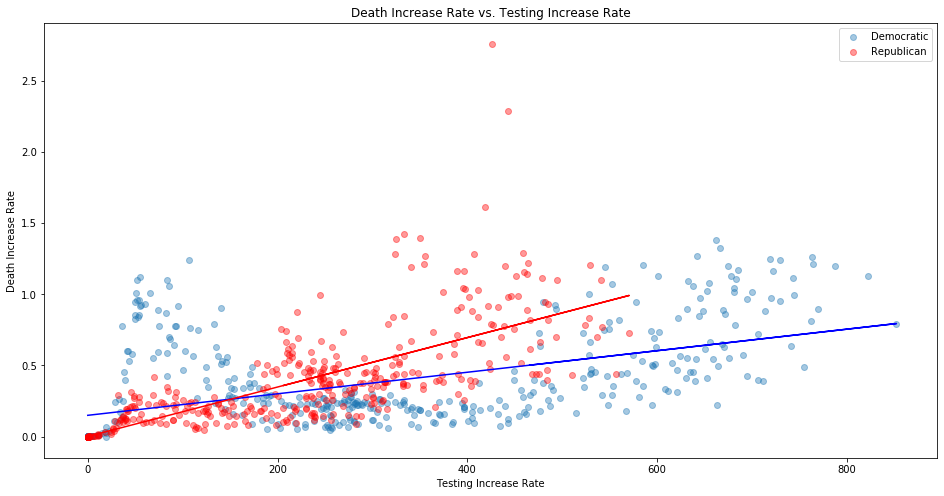

In [121]:
plt.figure(figsize=(16,8))
plt.scatter(Dem_covid['testingIncreaseRate'], Dem_covid['deathIncreaseRate'], alpha=0.4, label='Democratic')
plt.scatter(Rep_covid['testingIncreaseRate'], Rep_covid['deathIncreaseRate'], alpha=0.4, color='red', label='Republican')

lr = LinearRegression()
lr.fit(np.array(Dem_covid['testingIncreaseRate']).reshape(-1,1), Dem_covid['deathIncreaseRate'])
print('Democratic Estimate: y = {}x + {}'.format(lr.coef_[0], lr.intercept_))
plt.plot(Dem_covid['testingIncreaseRate'], lr.predict(np.array(Dem_covid['testingIncreaseRate']).reshape(-1,1)), color='blue')

lr.fit(np.array(Rep_covid['testingIncreaseRate']).reshape(-1,1), Rep_covid['deathIncreaseRate'])
print('Republican Estimate: y = {}x + {}'.format(lr.coef_[0], lr.intercept_))
plt.plot(Rep_covid['testingIncreaseRate'], lr.predict(np.array(Rep_covid['testingIncreaseRate']).reshape(-1,1)), color='red')

plt.xlabel('Testing Increase Rate')
plt.ylabel('Death Increase Rate')
plt.title('Death Increase Rate vs. Testing Increase Rate')
plt.legend()
plt.show()

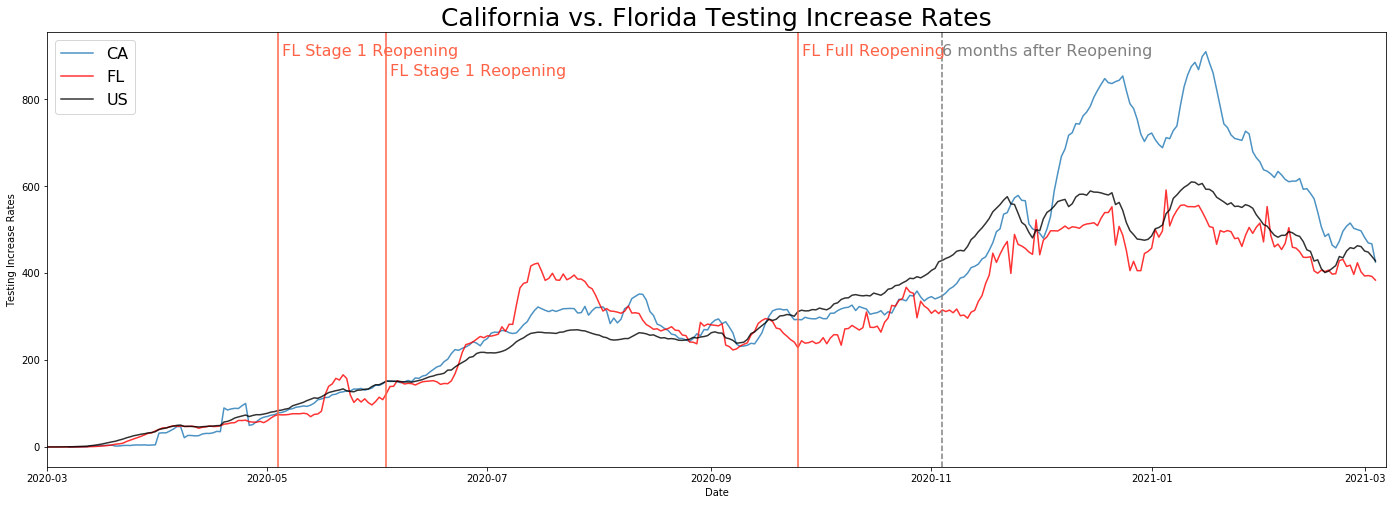

Full Time Frame
CA Average: 340.50386812323114
FL Average: 279.5989363011025
US Average: 297.9908846231975
F_onewayResult(statistic=7.738448402126859, pvalue=0.00045967284764869684)
SIGNIFICANT 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    CA     FL -60.9049  0.001 -98.1595 -23.6503   True
    CA     US  -42.513 0.0205 -79.7676  -5.2584   True
    FL     US  18.3919 0.4786 -18.7872  55.5711  False
------------------------------------------------------


After Reopening on 5/04/2020
CA Average: 402.0641669787608
FL Average: 331.2693166761591
US Average: 352.5139614346654
F_onewayResult(statistic=10.901738232167286, pvalue=2.092225537560887e-05)
SIGNIFICANT 

 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj   lower    upper   reject
------------------------------------------------------
    CA     FL -70.7949  0.001 -107.323 -34.2

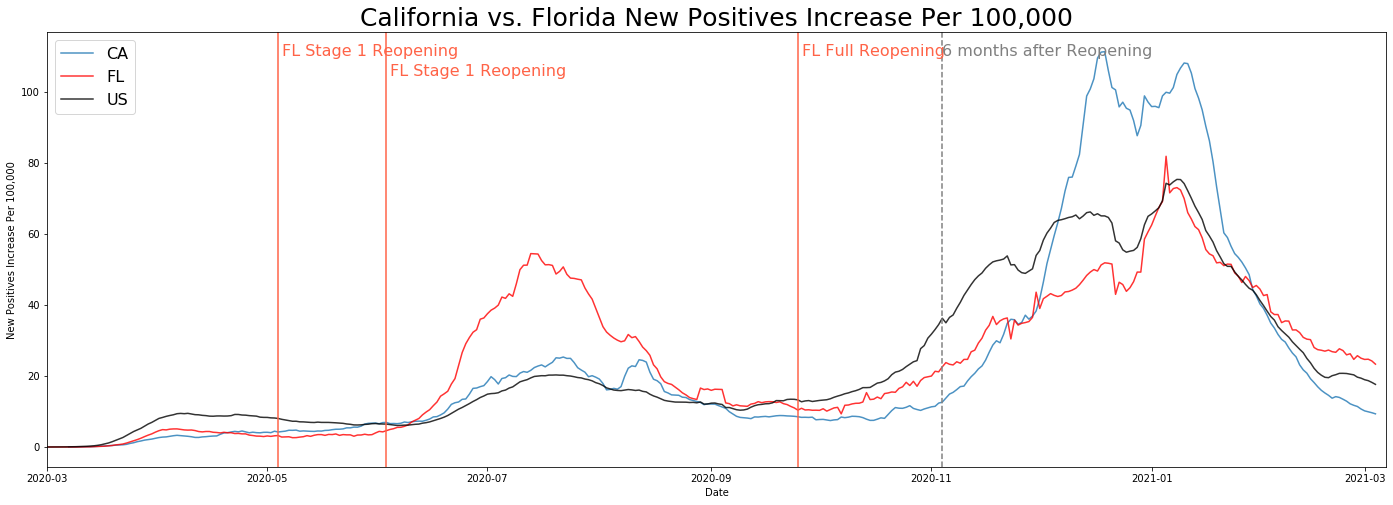

Full Time Frame
CA Average: 24.01466755563204
FL Average: 23.89582411808338
US Average: 23.553175352034263
F_onewayResult(statistic=0.036184020963477934, pvalue=0.9644639333475139)
NOT SIGNIFICANT 



After Reopening on 5/04/2020
CA Average: 28.330687482666875
FL Average: 28.334504652936147
US Average: 27.29888233338877
F_onewayResult(statistic=0.18140674188779393, pvalue=0.8341258238304653)
NOT SIGNIFICANT 



6 Months After Reopening on 5/04/2020
CA Average: 12.126168955158308
FL Average: 19.51524237601211
US Average: 13.761458899484495
F_onewayResult(statistic=25.420779821536126, pvalue=2.7485678444325342e-11)
SIGNIFICANT 

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    CA     FL   7.3891  0.001  4.8307  9.9475   True
    CA     US   1.6353 0.2912 -0.9231  4.1937  False
    FL     US  -5.7538  0.001 -8.3122 -3.1954   True
-----------------------------------------------

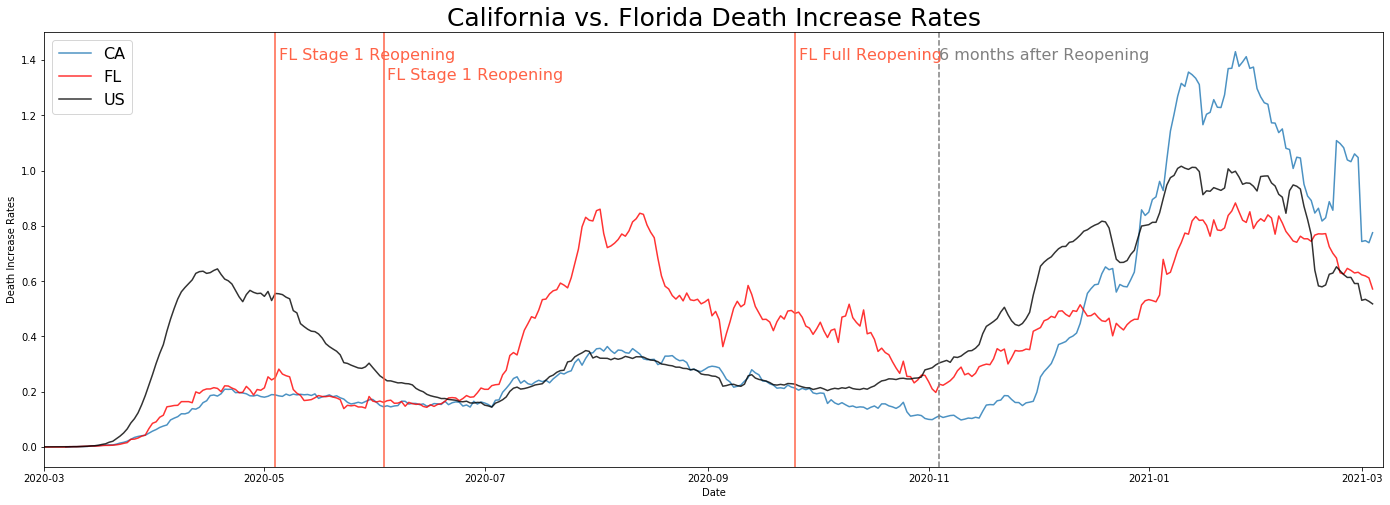

Full Time Frame
CA Average: 0.37122058856336126
FL Average: 0.4038440322636638
US Average: 0.4219357132092284
F_onewayResult(statistic=1.9621018137149224, pvalue=0.14104988751355035)
NOT SIGNIFICANT 



After Reopening on 5/04/2020
CA Average: 0.4265407043428415
FL Average: 0.46655076116513294
US Average: 0.446123879167755
F_onewayResult(statistic=0.9582523708168573, pvalue=0.3839447026559414)
NOT SIGNIFICANT 



6 Months After Reopening on 5/04/2020
CA Average: 0.21255140158472935
FL Average: 0.39583414312325443
US Average: 0.2667737207042509
F_onewayResult(statistic=42.31457825594809, pvalue=7.989224827652206e-18)
SIGNIFICANT 

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    CA     FL   0.1833  0.001  0.1352 0.2314   True
    CA     US   0.0542 0.0226  0.0061 0.1023   True
    FL     US  -0.1291  0.001 -0.1772 -0.081   True
--------------------------------------------------

In [129]:
us_covid['state'] = 'US'
tukey_data = pd.concat([CA_covid, FL_covid, us_covid])

y_coord = [900, 110, 1.4]
timeframe = [['2020-03-1','2021-03-07'],['2020-05-4','2021-03-07'],['2020-05-4','2020-11-4']]
time_frames_titles = ['Full Time Frame', 'After Reopening on 5/04/2020','6 Months After Reopening on 5/04/2020']

for i in range(len(cols_of_interest)):
    plt.figure(figsize=(24,8))
    c = cols_of_interest[i]
    title = titles[i]
    plt.plot( CA_covid['date'], CA_covid[c].rolling(7, center=True).mean(), alpha=0.8, label='CA')
    plt.plot(FL_covid['date'], FL_covid[c].rolling(7, center=True).mean(), color='red', alpha=0.8, label='FL')
    plt.plot(us_covid['date'], us_covid[c].rolling(7, center=True).mean(), color='black', alpha=0.8, label='US')
    
    plt.xlim(pd.to_datetime('2020-03-1'),pd.to_datetime('2021-03-07'))
    
    plt.axvline(x=pd.to_datetime('2020-05-4'), color='tomato')
    plt.text(pd.to_datetime('2020-05-5'), y_coord[i], 'FL Stage 1 Reopening', fontsize=16, color='tomato')
    
    plt.axvline(x=pd.to_datetime('2020-06-3'), color='tomato')
    plt.text(pd.to_datetime('2020-06-4'), y_coord[i]*0.95, 'FL Stage 1 Reopening', fontsize=16, color='tomato')
    
    plt.axvline(x=pd.to_datetime('2020-09-25'), color='tomato')
    plt.text(pd.to_datetime('2020-09-26'), y_coord[i], 'FL Full Reopening', fontsize=16, color='tomato')
    
    plt.axvline(x=pd.to_datetime('2020-11-4'), linestyle='--', color='grey')
    plt.text(pd.to_datetime('2020-11-4'), y_coord[i], '6 months after Reopening', fontsize=16, color='grey')

    plt.xlabel('Date')
    plt.ylabel(title)
    plt.title('California vs. Florida {}'.format(title), fontsize=25)
    plt.legend(loc=2, fontsize=16)
    plt.show()
    
    for j in range(len(timeframe)):
        CA_subset = CA_covid.loc[(CA_covid['date'] >= pd.Timestamp(timeframe[j][0])) & (CA_covid['date'] <= pd.Timestamp(timeframe[j][1]))]
        FL_subset = FL_covid.loc[(FL_covid['date'] >= pd.Timestamp(timeframe[j][0])) & (FL_covid['date'] <= pd.Timestamp(timeframe[j][1]))]
        us_subset = us_covid.loc[(us_covid['date'] >= pd.Timestamp(timeframe[j][0])) & (us_covid['date'] <= pd.Timestamp(timeframe[j][1]))]
        tukey_data = pd.concat([CA_subset, FL_subset, us_subset])
        
        print(time_frames_titles[j])
        print('CA Average: {}'.format(CA_subset[c].mean()))
        print('FL Average: {}'.format(FL_subset[c].mean()))
        print('US Average: {}'.format(us_subset[c].mean()))
        
        anova = stats.f_oneway(CA_subset[c], FL_subset[c], us_subset[c])
        is_significant = 'SIGNIFICANT' if anova.pvalue < 0.05 else 'NOT SIGNIFICANT'
        print(anova)
        print(is_significant, '\n')
        if is_significant == 'SIGNIFICANT':
            tukey = pairwise_tukeyhsd(endog=tukey_data[c], groups=tukey_data['state'], alpha=0.05)
            print(tukey)
        print('\n')

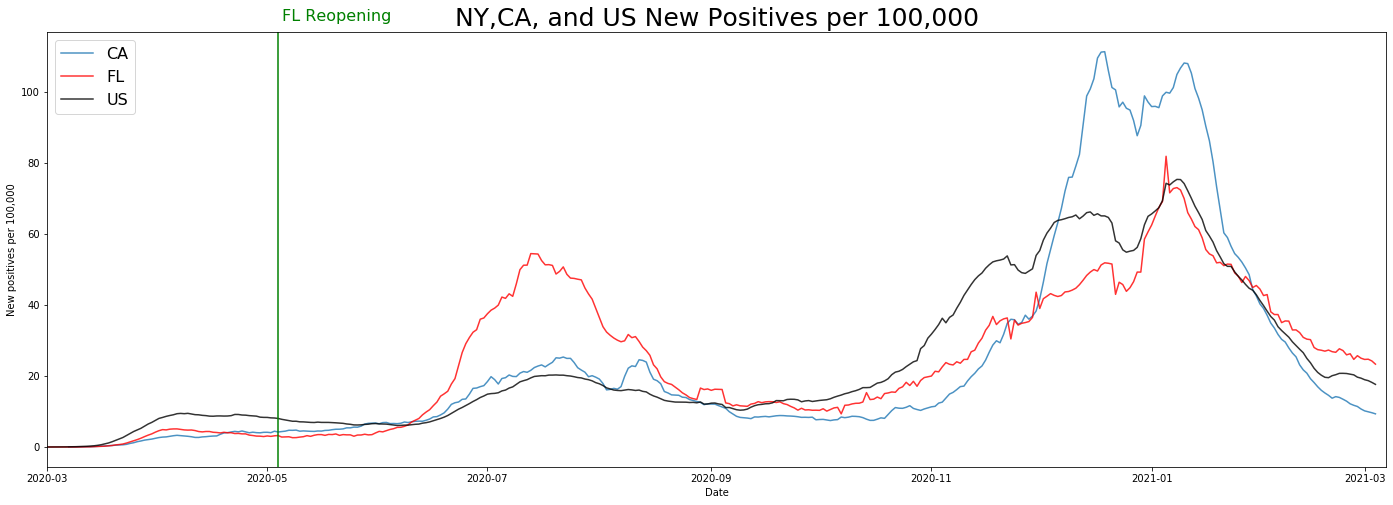

Ttest_indResult(statistic=-1.0857098364339022, pvalue=0.2779467286283205)


In [63]:
plt.figure(figsize=(24,8))
plt.plot(CA_covid['date'], CA_covid['positiveIncreaseRate'].rolling(7, center=True).mean(), alpha=0.8, label='CA')
plt.plot(FL_covid['date'], FL_covid['positiveIncreaseRate'].rolling(7, center=True).mean(), color='red', alpha=0.8, label='FL')
plt.plot(us_covid['date'], us_covid['positiveIncreaseRate'].rolling(7, center=True).mean(), color='black', alpha=0.8, label='US')

plt.axvline(x=pd.to_datetime('2020-05-4'), color='green')
plt.text(pd.to_datetime('2020-05-5'), 120, 'FL Reopening', fontsize=16, color='green')
plt.xlim(pd.to_datetime('2020-03-1'),pd.to_datetime('2021-03-07'))

plt.xlabel('Date')
plt.ylabel('New positives per 100,000')
plt.title('NY,CA, and US New Positives per 100,000', fontsize=25)
plt.legend(loc=2, fontsize=16)
plt.show()

print(stats.ttest_ind(FL_covid['positiveIncreaseRate'], CA_covid['positiveIncreaseRate']))

The above graph represents the new positive COVID-19 cases per 100,000 in New York (outlined in blue) and Florida (outlined in red). New York, being the US epicenter of COVID at the beginning of the pandemic, experienced its peak 3 months earlier than Florida experienced its first peak. During the holiday season of November to January, both New York and Florida experienced increases in cases. Florida experienced its greatest peak as of yet in January 2021, which may be attributed to out-of-state travel to Florida for holidays breaks. Both New York and Florida have significantly been above the US in terms of cases per population since the beginning of the pandemic in March 2020, except for the period between November to January, which again may be attributed to holiday travel. We conducted a t-test where our null hypothesis was that the difference in the means of the positives of NY and FL was 0. Since our p value was .4205, if we test at a significant level of 0.05, there is an insignificant difference between the means of COVID cases in New York and Florida during the period of the graph.


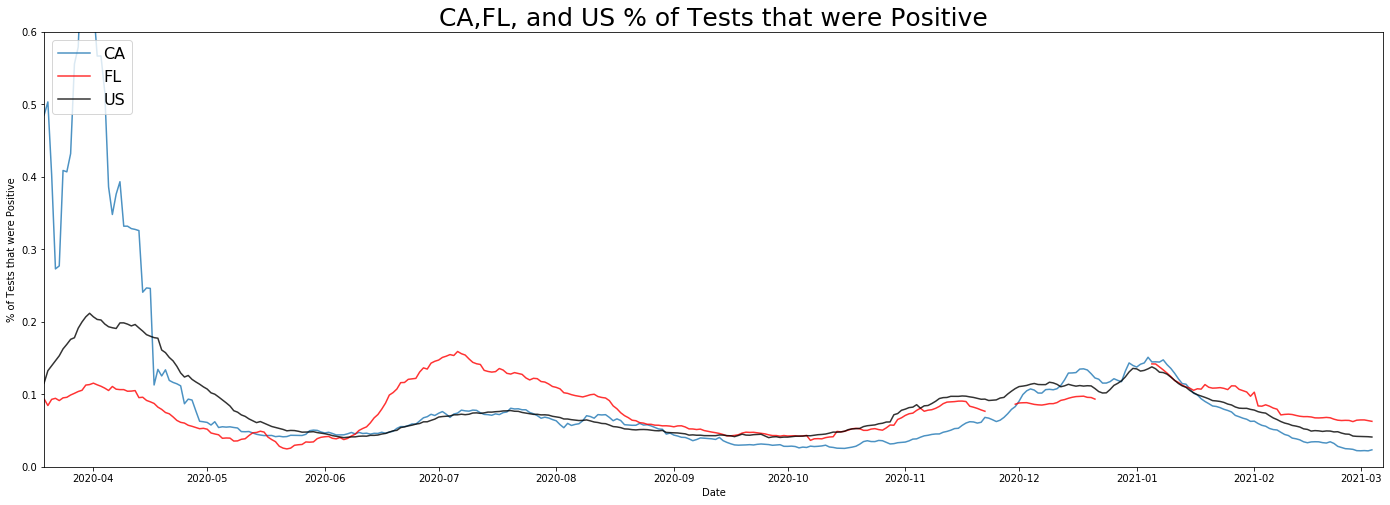

Ttest_indResult(statistic=-3.0594287980568535, pvalue=0.0022976433233061156)


In [80]:
plt.figure(figsize=(24,8))
plt.plot(CA_covid['date'], CA_covid['percentPositiveIncrease'].rolling(7, center=True).mean(), alpha=0.8, label="CA")
plt.plot(FL_covid['date'], FL_covid['percentPositiveIncrease'].rolling(7, center=True).mean(), color='red', alpha=0.8, label="FL")
plt.plot(us_covid['date'], us_covid['percentPositiveIncrease'].rolling(7, center=True).mean(), color='black', alpha=0.8, label="US")
plt.xlim(pd.to_datetime('2020-03-19'),pd.to_datetime('2021-03-07'))
plt.ylim(0,0.6)
plt.xlabel('Date')
plt.ylabel('% of Tests that were Positive')
plt.title('CA,FL, and US % of Tests that were Positive', fontsize=25)
plt.legend(loc=2, fontsize=16)
plt.show()

print(stats.ttest_ind(FL_covid['percentPositiveIncrease'].dropna(), CA_covid['percentPositiveIncrease'].dropna()))

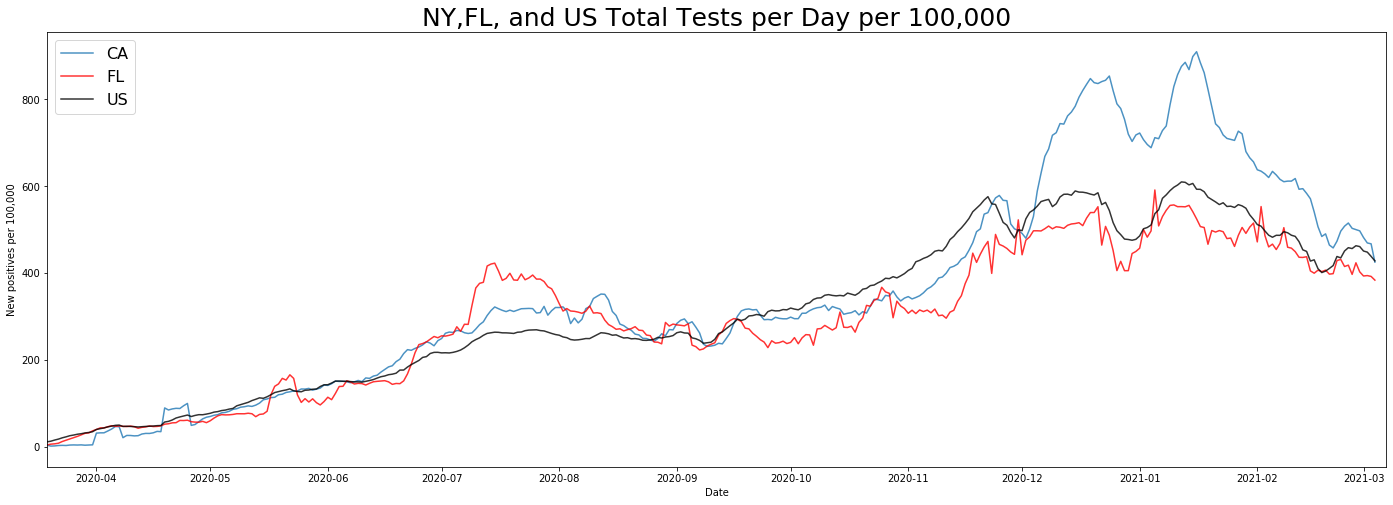

Ttest_indResult(statistic=-14.310519805428594, pvalue=2.2783584619224527e-41)


In [6]:
plt.figure(figsize=(24,8))
plt.plot(CA_covid['date'], CA_covid['testingIncreaseRate'].rolling(7, center=True).mean(), alpha=0.8, label="CA")
plt.plot(FL_covid['date'], FL_covid['testingIncreaseRate'].rolling(7, center=True).mean(), color='red', alpha=0.8, label="FL")
plt.plot(us_covid['date'], us_covid['testingIncreaseRate'].rolling(7, center=True).mean(), color='black', alpha=0.8, label="US")
plt.xlim(pd.to_datetime('2020-03-19'),pd.to_datetime('2021-03-07'))
plt.xlabel('Date')
plt.ylabel('New positives per 100,000')
plt.title('NY,FL, and US Total Tests per Day per 100,000', fontsize=25)
plt.legend(loc=2, fontsize=16)
plt.show()

print(stats.ttest_ind(FL_covid['totalTestResultsIncrease'].dropna(), CA_covid['totalTestResultsIncrease'].dropna()))

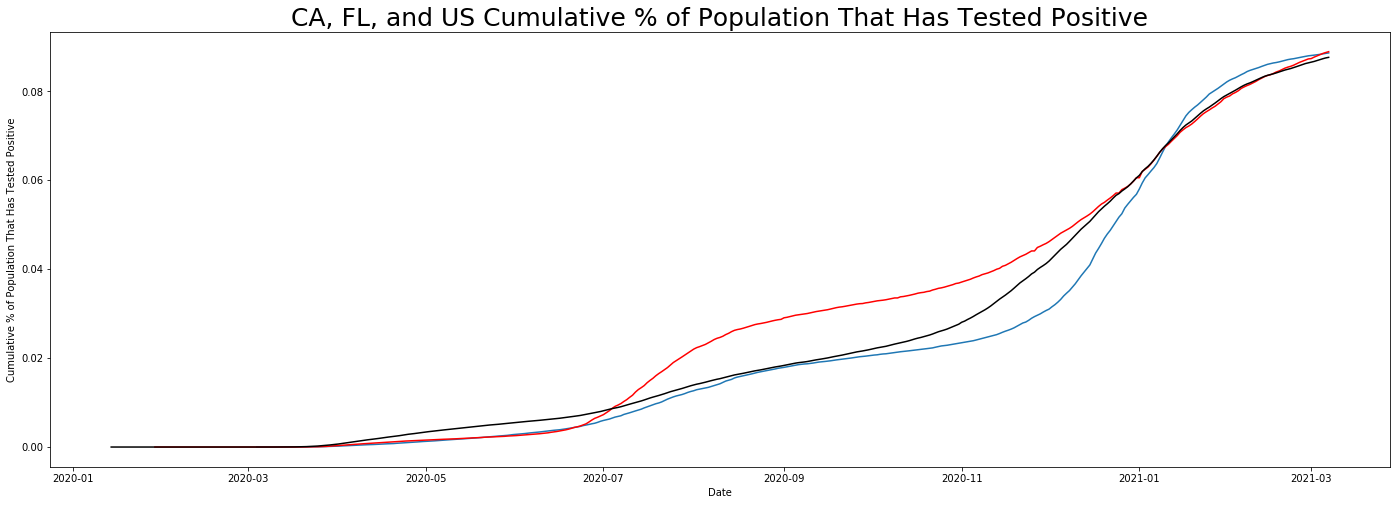

In [76]:
plt.figure(figsize=(24,8))
plt.plot(CA_covid['date'], CA_covid['positiveRate'])
plt.plot(FL_covid['date'], FL_covid['positiveRate'], color='red')
plt.plot(us_covid['date'], us_covid['positiveRate'], color='black')
plt.xlabel('Date')
plt.ylabel('Cumulative % of Population That Has Tested Positive')
plt.title('CA, FL, and US Cumulative % of Population That Has Tested Positive', fontsize=25)
plt.show()

New York and Florida have had similar trajectories to each other and to the United States as a whole in regard to cumulative percent of the population that have tested positive. However, NY, FL, and the US experienced the greatest increases at different times. While the rate of exposure was greatest for New York in March 2020, Florida’s largest rate of increase did not occur until 3-4 months later in July 2020. Additionally, the United States’ greatest increase was during the holiday season between November 2020 and January 2021. 

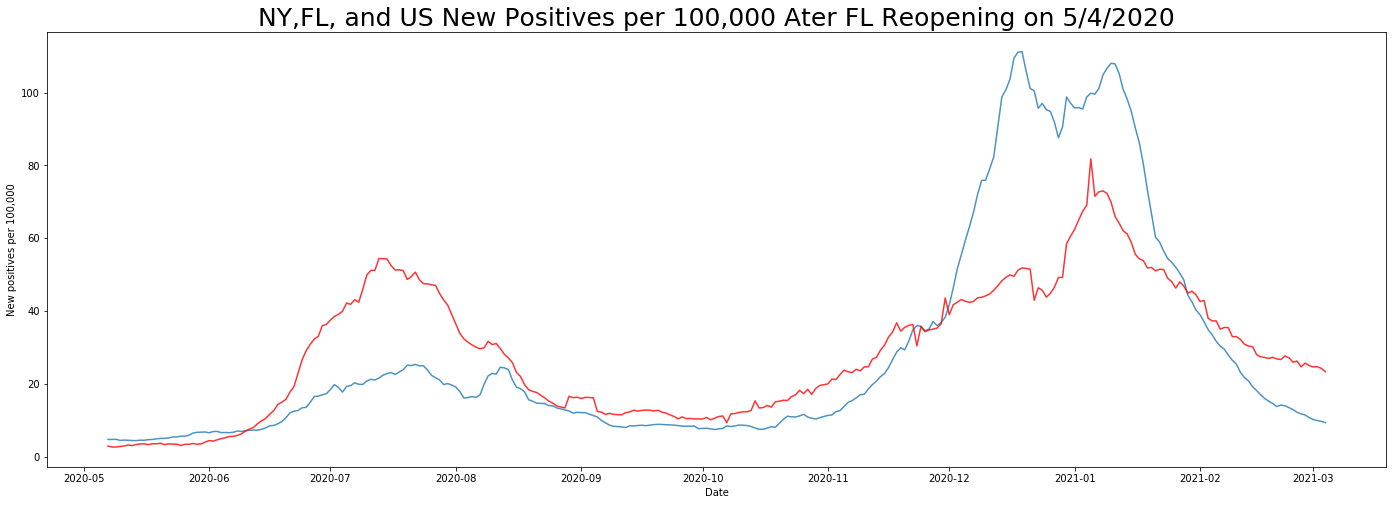

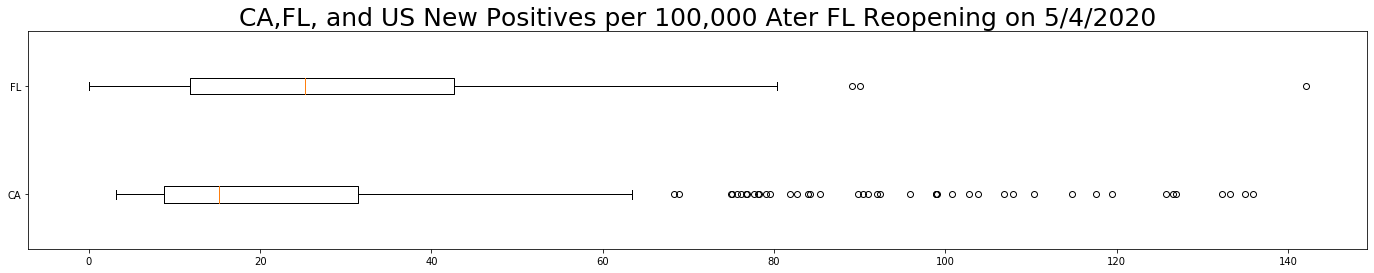

Ttest_indResult(statistic=0.001804369304550121, pvalue=0.9985609084407683)


In [69]:
# New Positivies of FL and NY after FL Reopening on 5/4/2020

FL_subset = FL_covid.loc[FL_covid['date'] >= pd.Timestamp('2020-05-04')]
CA_subset = CA_covid.loc[CA_covid['date'] >= pd.Timestamp('2020-05-04')]

plt.figure(figsize=(24,8))
plt.plot(CA_subset['date'], CA_subset['positiveIncreaseRate'].rolling(7, center=True).mean(), alpha=0.8)
plt.plot(FL_subset['date'], FL_subset['positiveIncreaseRate'].rolling(7, center=True).mean(), color='red', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('New positives per 100,000')
plt.title('NY,FL, and US New Positives per 100,000 Ater FL Reopening on 5/4/2020', fontsize=25)
plt.show()

#both_subset = pd.concat([NY_subset, FL_subset])
#both_subset.boxplot('positiveIncrease', by='state', vert=False)
plt.figure(figsize=(24,4))
plt.boxplot([CA_subset['positiveIncreaseRate'], FL_subset['positiveIncreaseRate']], labels=['CA', 'FL'], vert=False)
plt.title('CA,FL, and US New Positives per 100,000 Ater FL Reopening on 5/4/2020', fontsize=25)
plt.show()

print(stats.ttest_ind(FL_subset['positiveIncreaseRate'], CA_subset['positiveIncreaseRate']))

This is a graph of the increase in new positive cases per 100,000 people over time specifically after May 4, 2020, when Florida started reopening at stage 1. At this stage, restaurants, stores, libraries, museums were allowed to be open to 25%. After this point many other businesses began to open. However, New York did not begin phase 1 opening until June 8, 2020.

We conducted a t-test to determine if the difference in mean positive increase rates is statistically significant for NY and FL after 5/4/2020. The hypothesis was that the difference in means is 0. The null hypothesis is that the difference is not 0. I will reject the hypothesis that the p-value is less than 0.05. The calculated p-value was 0.00236. I reject the hypothesis and have statistically significant evidence to suggest that the difference in mean positive increase rates for NY and FL are different.

The boxplots are also of the  increase in positive covid cases per 100,000 of NY and FL. Based on the boxplot, you can tell that the FL's median is higher than NY's. NY also looks to be right skewed while FL does not. The lower half of NY's data had very little spread, meaning they were consistently low.

We know that the newly hospitalized data needs additional cleaning. NY's hospitalIncrease column is always zero from 6/3/2020 and onwards. We tried to measure cuurentlyHospitalized instead, but FL does not have any of this data until 7/10/2020. We're unsure if we will use this portion of data in the final project or not at the moment.

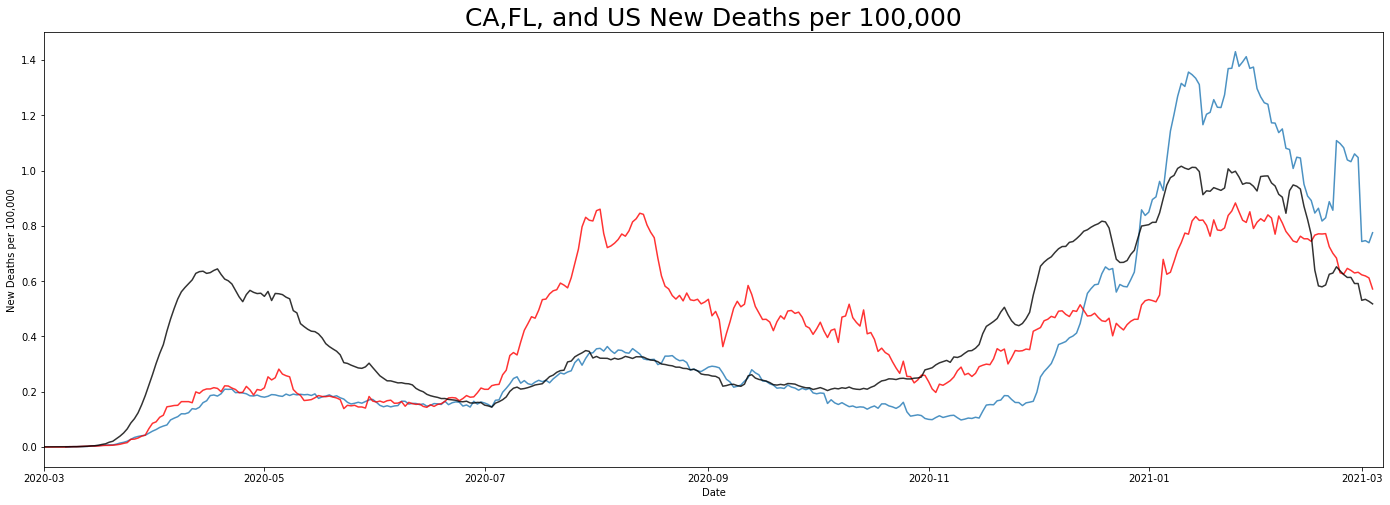

Ttest_indResult(statistic=1.3158607303168102, pvalue=0.1887118672852537)


In [70]:
plt.figure(figsize=(24,8))
plt.plot(CA_covid['date'], CA_covid['deathIncreaseRate'].rolling(7, center=True).mean(), alpha=0.8)
plt.plot(FL_covid['date'], FL_covid['deathIncreaseRate'].rolling(7, center=True).mean(), color='red', alpha=0.8)
plt.plot(us_covid['date'], us_covid['deathIncreaseRate'].rolling(7, center=True).mean(), color='black', alpha=0.8)
plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-03-07'))
plt.xlabel('Date')
plt.ylabel('New Deaths per 100,000')
plt.title('CA,FL, and US New Deaths per 100,000', fontsize=25)
plt.show()

print(stats.ttest_ind(FL_subset['deathIncreaseRate'], CA_subset['deathIncreaseRate']))

Similarly, we graphed the number of people newly hospitalized and the number of deaths per 100,000 by date for New York, FLorida, and the United States. New York had a spike in both newly hospitalized patients and deaths from March to June of 2020. 

We conducted several t-tests to determine if the difference in mean hospitalized increase rates  and the difference in mean death rates were statistically significant for NY and FL after 5/4/2020. The p-values were approximately zero, so we have statistically significant evidence to suggest that the mean hospitalized increase rates and the mean death rates are different for NY and Florida.


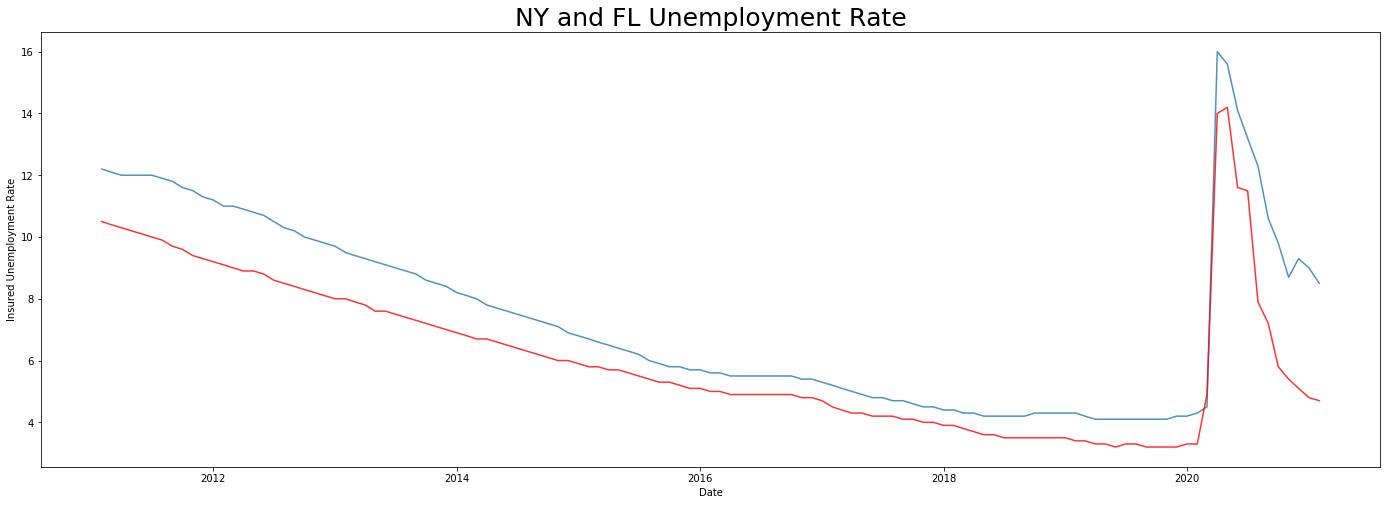

10.007142857142856
Ttest_indResult(statistic=1.7711076756057795, pvalue=0.08826657999756307)


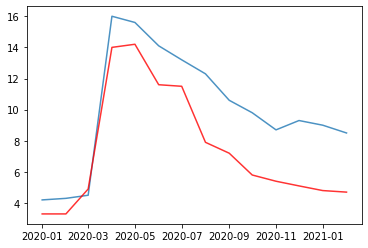

In [42]:
plt.figure(figsize=(24,8))
plt.plot(state_unemployment['Date'], state_unemployment['California'], alpha=0.8)
plt.plot(state_unemployment['Date'], state_unemployment['Florida'], alpha=0.8, color='red')
#plt.plot(FL_Unemployment['filed_week_ended'], FL_Unemployment['insured_unemployment_rate'], color='red', alpha=0.8)
#plt.plot(us_covid['date'], us_covid['deathIncreaseRate'], color='black', alpha=0.8)
#plt.xlim(pd.Timestamp('2020-03-01'), pd.Timestamp('2021-03-01'))
plt.xlabel('Date')
plt.ylabel('Insured Unemployment Rate')
plt.title('NY and FL Unemployment Rate', fontsize=25)
plt.show()

subset = state_unemployment.loc[state_unemployment['Date'] >= pd.Timestamp('2020-01-01')]
print(subset['California'].mean())
print(stats.ttest_ind(subset['California'], subset['Florida']))

plt.plot(subset['Date'], subset['California'], alpha=0.8)
plt.plot(subset['Date'], subset['Florida'], alpha=0.8, color='red')

The above graph compares the Insured Unemployment Rate of both Florida and New York from the beginning of 2020 to early 2021. Insured Unemployment rate is the number collecting unemployment as a percentage of the workforce overall. Here, we see a clear, unprecedented explosion in both states around the emergence of COVID-19 and related policy actions. Florida’s dramatic rise and fall is a consequence of policy which shut down businesses between April and May, only to allow a substantial portion of those businesses to reopen in June. New York maintained a high level of unemployment and shallower decline over time on account of it’s phase, much slower reopening plan.

## Questions for Reviewers
- For phase 3, how should we go about deciding what analyses we should vow to present in the final report?
- What time frame would you recommend for studying the effect of a policy after it was enacted?
- We’re considering adding more states to see how similar policies affected similar states in different (or similar) ways. Would an ANOVA test be appropriate for comparing means across several states? 
- We are looking at PPP loans as an indicator of unemployment and losses that businesses faced, but since so many people took this loan that may not have necessarily needed it because of the low interest rates, we fear that PPP loans will not be a good indicator of economic health. Do you have any suggestions for other indicators we can look at?

